# Generation Using GRU
    using Shakespeare Text to train a GRU model for text generation

### RNN vs LSTM vs GRU
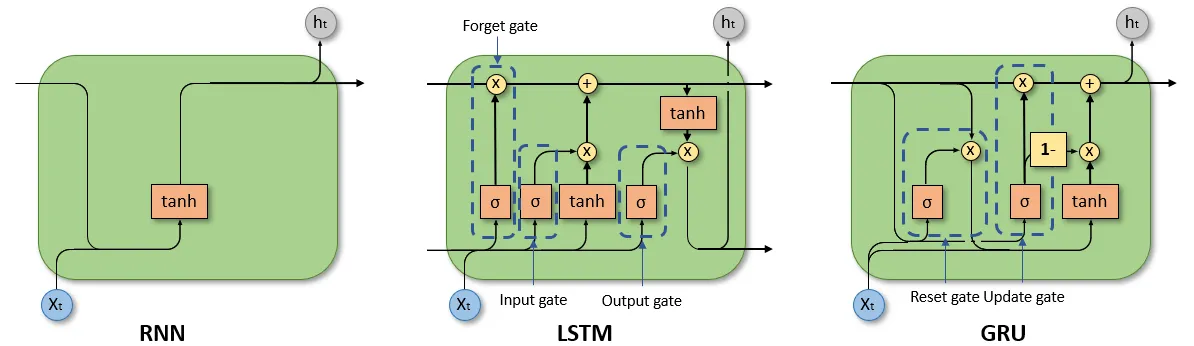
    LSTM and GRU are variants of RNNs that include additional structures to better capture long-term dependencies.

# GRU (Gated Recurrent Unit)

https://pytorch.org/docs/stable/generated/torch.nn.GRU.html

    torch.nn.GRU(input_size, hidden_size, num_layers=1, bias=True, batch_first=False, dropout=0.0, bidirectional=False, device=None, dtype=None)

> ### Parameters
> - input_size – The number of expected features in the input x
> - hidden_size – The number of features in the hidden state h
> - num_layers – Number of recurrent layers. Default: 1 
> - bias – If False, then the layer does not use bias weights b_ih and b_hh. Default: True
> - batch_first – If True, then the input and output tensors are provided as (batch, seq, feature) instead of (seq, batch, feature). Default: False
> - dropout – If non-zero, introduces a Dropout layer on the outputs of each RNN layer except the last layer. Default: 0
> - bidirectional – If True, becomes a bidirectional RNN. Default: False

   - **Update Gate**: Controls the degree to which the hidden state is updated with new information.
   - **Reset Gate**: Determines how much of the past information should be forgotten.


## GRU for Shakespeare Text Generation

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

In [2]:
# Load the Shakespeare text
with open('ali_karimi.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# Create mappings from characters to indices and vice versa
chars = sorted(list(set(text)))
char_to_idx = {ch: idx for idx, ch in enumerate(chars)}
idx_to_char = {idx: ch for idx, ch in enumerate(chars)}
vocab_size = len(chars)

In [3]:
print(chars)

['\t', '\n', ' ', '(', ')', '-', '.', '/', ':', 'A', 'B', 'C', 'F', 'K', '[', ']', 'a', 'e', 'f', 'i', 'k', 'l', 'm', 'n', 'r', 's', 't', '§', '«', '»', '،', '؛', 'ء', 'آ', 'أ', 'ؤ', 'ئ', 'ا', 'ب', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 'ز', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ', 'ف', 'ق', 'ل', 'م', 'ن', 'ه', 'و', 'ً', 'ِ', 'ٔ', '٪', '٫', 'پ', 'چ', 'ژ', 'ک', 'گ', 'ی', '۰', '۱', '۲', '۳', '۴', '۵', '۶', '۷', '۸', '۹', '\u200c', '\u200f', '–', '−']


In [4]:
print(char_to_idx)

{'\t': 0, '\n': 1, ' ': 2, '(': 3, ')': 4, '-': 5, '.': 6, '/': 7, ':': 8, 'A': 9, 'B': 10, 'C': 11, 'F': 12, 'K': 13, '[': 14, ']': 15, 'a': 16, 'e': 17, 'f': 18, 'i': 19, 'k': 20, 'l': 21, 'm': 22, 'n': 23, 'r': 24, 's': 25, 't': 26, '§': 27, '«': 28, '»': 29, '،': 30, '؛': 31, 'ء': 32, 'آ': 33, 'أ': 34, 'ؤ': 35, 'ئ': 36, 'ا': 37, 'ب': 38, 'ت': 39, 'ث': 40, 'ج': 41, 'ح': 42, 'خ': 43, 'د': 44, 'ذ': 45, 'ر': 46, 'ز': 47, 'س': 48, 'ش': 49, 'ص': 50, 'ض': 51, 'ط': 52, 'ظ': 53, 'ع': 54, 'غ': 55, 'ف': 56, 'ق': 57, 'ل': 58, 'م': 59, 'ن': 60, 'ه': 61, 'و': 62, 'ً': 63, 'ِ': 64, 'ٔ': 65, '٪': 66, '٫': 67, 'پ': 68, 'چ': 69, 'ژ': 70, 'ک': 71, 'گ': 72, 'ی': 73, '۰': 74, '۱': 75, '۲': 76, '۳': 77, '۴': 78, '۵': 79, '۶': 80, '۷': 81, '۸': 82, '۹': 83, '\u200c': 84, '\u200f': 85, '–': 86, '−': 87}


In [5]:
print(idx_to_char)

{0: '\t', 1: '\n', 2: ' ', 3: '(', 4: ')', 5: '-', 6: '.', 7: '/', 8: ':', 9: 'A', 10: 'B', 11: 'C', 12: 'F', 13: 'K', 14: '[', 15: ']', 16: 'a', 17: 'e', 18: 'f', 19: 'i', 20: 'k', 21: 'l', 22: 'm', 23: 'n', 24: 'r', 25: 's', 26: 't', 27: '§', 28: '«', 29: '»', 30: '،', 31: '؛', 32: 'ء', 33: 'آ', 34: 'أ', 35: 'ؤ', 36: 'ئ', 37: 'ا', 38: 'ب', 39: 'ت', 40: 'ث', 41: 'ج', 42: 'ح', 43: 'خ', 44: 'د', 45: 'ذ', 46: 'ر', 47: 'ز', 48: 'س', 49: 'ش', 50: 'ص', 51: 'ض', 52: 'ط', 53: 'ظ', 54: 'ع', 55: 'غ', 56: 'ف', 57: 'ق', 58: 'ل', 59: 'م', 60: 'ن', 61: 'ه', 62: 'و', 63: 'ً', 64: 'ِ', 65: 'ٔ', 66: '٪', 67: '٫', 68: 'پ', 69: 'چ', 70: 'ژ', 71: 'ک', 72: 'گ', 73: 'ی', 74: '۰', 75: '۱', 76: '۲', 77: '۳', 78: '۴', 79: '۵', 80: '۶', 81: '۷', 82: '۸', 83: '۹', 84: '\u200c', 85: '\u200f', 86: '–', 87: '−'}


In [6]:
vocab_size

88

In [7]:
# Define character-level dataset
class CharDataset(Dataset):
    def __init__(self, text, seq_length):
        self.text = text  # Store the raw text
        self.seq_length = seq_length  # Store the sequence length
        
        # Create a sorted list of unique characters and mapping from characters to indices
        self.chars = sorted(list(set(text)))
        self.char2idx = {c: i for i, c in enumerate(self.chars)}
        self.idx2char = {i: c for i, c in enumerate(self.chars)}
        
        # Convert the text to a list of indices
        self.data = [self.char2idx[c] for c in text]

    def __len__(self):
        # Return the number of possible sequences in the dataset
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        # Get a sequence of data and the corresponding target sequence
        seq = self.data[idx:idx+self.seq_length]
        target = self.data[idx+1:idx+self.seq_length+1]
        
        # Return the sequences as tensors
        return torch.tensor(seq, dtype=torch.long), torch.tensor(target, dtype=torch.long)


In [8]:
# Define the GRU model
class GRUModel(nn.Module):
    def __init__(self, vocab_size, hidden_size, num_layers=1):
        super(GRUModel, self).__init__()
        # Store the hidden size and number of layers
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Define an embedding layer to convert input indices to dense vectors
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        
        # Define a GRU layer
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers, batch_first=True)
        
        # Define a fully connected layer to produce output logits for each vocabulary token
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden=None):
        # Apply the embedding layer
        x = self.embedding(x)
        
        # Pass the embedded input through the GRU layer
        out, hidden = self.gru(x, hidden)
        
        # Apply the fully connected layer to produce the final output
        out = self.fc(out)
        
        return out, hidden

    def init_hidden(self, batch_size):
        # Initialize the hidden state with zeros
        return torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)


In [15]:
# Hyperparameters
seq_length = 100
hidden_size = 50
num_layers = 1
num_epochs = 20
batch_size = 64
learning_rate = 0.002

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Prepare dataset and dataloader
dataset = CharDataset(text, seq_length)
vocab_size = len(dataset.chars)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

# Instantiate the model, loss function, and optimizer
model = GRUModel(vocab_size, hidden_size, num_layers).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
# Function to generate text
def generate_text(model, start_text, length, temperature=1.0):
    # Set the model to evaluation mode
    model.eval()
    
    # Initialize the hidden state for the model with batch size 1
    hidden = model.init_hidden(1)
    
    # Convert start_text to a tensor of character indices, then add a batch dimension and move to the appropriate device
    input_seq = torch.tensor([dataset.char2idx[c] for c in start_text], dtype=torch.long).unsqueeze(0).to(device)
    
    # Initialize the generated text with the start text
    generated_text = start_text

    # Disable gradient calculation
    with torch.no_grad():
        for _ in range(length):
            # Get the model's output and updated hidden state
            output, hidden = model(input_seq, hidden)
            
            # Adjust the output using the temperature parameter
            output = output[:, -1, :] / temperature
            
            # Apply softmax to get probabilities for the next character
            probs = nn.functional.softmax(output, dim=-1).squeeze()
            
            # Sample the next character index from the probability distribution
            char_idx = torch.multinomial(probs, 1).item()
            
            # Convert the character index back to a character
            char = dataset.idx2char[char_idx]
            
            # Append the character to the generated text
            generated_text += char
            
            # Update the input sequence with the new character index
            input_seq = torch.tensor([[char_idx]], dtype=torch.long).to(device)

    return generated_text


Epoch [1/20], Loss: 1.9628
Epoch [2/20], Loss: 1.4521
Generated Text after Epoch 2:
علی کریمی در لیگ قهرمانی که حفظ ایوست و به رفته منیخ نهاهشته پرسپولیس دند. اما با ژیم از سرانی ۲–۱ در کارد از ژازیک شد».[۱۵۹] سالفدید پس برانی را از دادن تیم ملی
ماند.[۲۸]

تین مستیل موفق زلی این جام جهانتان کمیت به دوده بودن که خوز این فصل را بازی تقهلاه پیراه ماتر آلمان دیگرت بازگشته‌ایش کریمی و ۳ فنبست‌و فوتقال به تیم ملی ایران را صح علال اما در موامده‌است.[۲۱۷]

فتح گیرانان تپامر تیم ملی ۲۰ بربب خود) در حالی از شد[۲۲] با[۱۴۰] در لیگ‌های آسیا دارلان به‌مید.[۲۰۲] در در بازیکن ای‌کدارات در رده از تهیسه‌د

Epoch [3/20], Loss: 1.3545
Epoch [4/20], Loss: 1.3113
Generated Text after Epoch 4:
علی کریمی اعتقات ایوش به علکل قرار گرفت و بازی شد.[۳۲]

تیم همرانان از شکست داد و در سال در مقابل تیم دود بیشناهام او آرایین دود.[۱۲۲]

موبنس باز.[۱۲۰] در حبه جمان قطیتان با کریمی خداقل در مسابقات لیگ کره جام در مومی، پیش خارج برای عنوان جام حضور در آغاز قطر حبت‌هه در سال ۱۳۷۶، امراه، و بازیکن را گل به عنوان، برای از ص

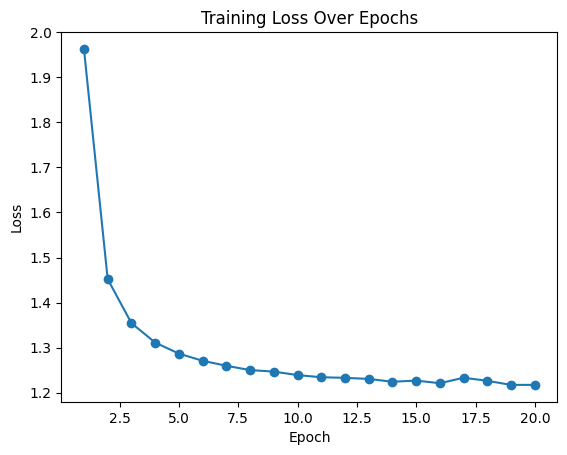

In [11]:
# Training loop
losses = []
for epoch in range(num_epochs):
    # Set the model to training mode
    model.train()
    
    # Initialize running loss for this epoch
    running_loss = 0.0
    
    # Initialize the hidden state for the model with batch size
    hidden = model.init_hidden(batch_size)
    
    # Iterate over the data loader
    for inputs, targets in dataloader:
        # Move inputs and targets to the appropriate device
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Zero the gradients for the optimizer
        optimizer.zero_grad()

        # Detach hidden state to prevent backpropagation through the entire history
        hidden = hidden.detach()
        
        # Get model outputs and updated hidden state
        outputs, hidden = model(inputs, hidden)
        
        # Compute the loss
        loss = criterion(outputs.view(-1, vocab_size), targets.view(-1))
        
        # Backpropagate the loss
        loss.backward()
        
        # Update model parameters
        optimizer.step()
        
        # Accumulate running loss
        running_loss += loss.item()
    
    # Calculate average loss for this epoch
    epoch_loss = running_loss / len(dataloader)
    losses.append(epoch_loss)
    
    # Print loss for the current epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
    
    # Generate and print text every 5 epochs
    if (epoch + 1) % 2 == 0:
        start_text = "علی کریمی "
        generated_text = generate_text(model, start_text, length=500)
        print(f"Generated Text after Epoch {epoch+1}:\n{generated_text}\n")

# Plot the training loss
plt.plot(range(1, num_epochs + 1), losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()

In [12]:
# Generate and print text
start_text = "علی کریمی " 
generated_text = generate_text(model, start_text, length=500)
print(generated_text)

علی کریمی از مسابقات ۲ چند علی کریمی لیگ برتر فوتبال ایران در این تیم ملایت شالکد ۱۹۹۸؛ بازماند.[۹۹] کود.

در بازی رفت.[۱۲۴] کریمی پس از بازگشت با روو برگزارش تهران آذر ۱۴۰۱ در نها به مثابلانی این دود کریمی علی

در سال ۱۳۸۹ با علزش از بود اما مان در بود ابلاگاگاه تماری تیم ملی آگریرن جدا پرسپولیس به ثمر رساند و در این این حبورده کریمی در صاهاری لیگ قبه بنامی از ترشین ملت‌های آسیا از ۳ بازی مقابل سال فوتبقکریحخوزده، در مجاست الاتی، مقابل این فصل را از کستن سابی فوتبال ایران در ازدن ۸ گل با حمایت.[۱۷۳]

مقا


In [13]:
torch.save(model, 'gru_text_generation_modelـfa.pth')